In [2]:
import numpy as np

def getTrainingData():
    return np.genfromtxt("training.csv", delimiter=",", dtype=np.int)

def getValidationData():
    return np.genfromtxt("validation.csv", delimiter=",", dtype=np.int)

def getUsefulStats(training):
    movies = [x[0] for x in training]
    u_movies = np.unique(movies).tolist()

    users = [x[1] for x in training]
    u_users = np.unique(users).tolist()

    return {
        "movies": movies, # movie IDs
        "u_movies": u_movies, # unique movie IDs
        "n_movies": len(u_movies), # number of unique movies

        "users": users, # user IDs
        "u_users": u_users, # unique user IDs
        "n_users": len(u_users), # number of unique users

        "ratings": [x[2] for x in training], # ratings
        "n_ratings": len(training) # number of ratings
    }

def rmse(r, r_hat):
    r = np.array(r)
    r_hat = np.array(r_hat)
    return np.linalg.norm(r - r_hat) / np.sqrt(len(r))

def getRatingsForUser(user, training):
    # user is a user ID
    # training is the training set
    # ret is a matrix, each row is [m, r] where
    #   m is the movie ID
    #   r is the rating, 1, 2, 3, 4 or 5
    return np.array([[x[0], x[2]] for x in training if x[1] == user])

In [3]:
# shape is movie,user,rating
training = getTrainingData()
validation = getValidationData()

#some useful stats
trStats = getUsefulStats(training)
vlStats = getUsefulStats(validation)
rBar = np.mean(trStats["ratings"])

# biases in the A matrix are in the order of movies before users, with index given as m and u
def getA(training):
    A = np.zeros((trStats["n_ratings"], trStats["n_movies"] + trStats["n_users"]))
    for i in range(trStats["n_ratings"]):
        m = training[i,0]
        u = training[i,1] + trStats["n_movies"]
        A[i,m] = 1
        A[i,u] = 1
    A = np.matrix(A)
    return A

# returns a vector c that equals to rating-mean of ratings
def getc(training):
    c = [x[2] for x in training] - rBar
    c = np.transpose(np.matrix(c))
    return c

# returns a parameter based on a linear regression model (without regularization)
def param(A, c):
    b = np.linalg.pinv(np.transpose(A)*A)*np.transpose(A)*c
    return b

# compute the estimator b with a regularisation parameter l
# note: lambda is a Python keyword to define inline functions
#       so avoid using it as a variable name!
def param_reg(A, c, l):
    b = np.linalg.pinv(np.transpose(A)*A-l*np.identity(A.shape[1]))*np.transpose(A)*c
    return b

# returns a vector p from b predicting the ratings for the (movies, users) pair
def predict(movies, users, rBar, b):
    n_predict = len(users)
    p = np.zeros(n_predict)
    for i in range(0, n_predict):
        rating = rBar + b[movies[i],0] + b[trStats["n_movies"] + users[i],0]
        if rating > 5: rating = 5.0
        if rating < 1: rating = 1.0
        p[i] = rating
    return p

In [4]:
A = getA(training)
c = getc(training)
# unregularized
b = param(A,c)
p = predict(trStats["movies"],trStats["users"],rBar,b)
p_v = predict(vlStats["movies"],vlStats["users"],rBar,b)
error = rmse(p,trStats["ratings"])
error_v = rmse(p_v,vlStats["ratings"])
print ("Linear regression without regularization")
print ("RMSE for training %f" % error)
print ("RMSE for validation %f \n" % error_v)
# regularized
l = 1.0
b = param_reg(A,c,l)
p = predict(trStats["movies"],trStats["users"],rBar,b)
p_v = predict(vlStats["movies"],vlStats["users"],rBar,b)
error = rmse(p,trStats["ratings"])
error_v = rmse(p_v,vlStats["ratings"])
print ("Linear regression with regularization, l = %f" % l)
print ("RMSE for training %f" % error)
print ("RMSE for validation %f" % error_v)

Linear regression without regularization
RMSE for training 0.883550
RMSE for validation 1.031098 

Linear regression with regularization, l = 1.000000
RMSE for training 0.949503
RMSE for validation 1.083131


In [20]:
import numpy as np
import scipy.special

# set highest rating
K = 5

def softmax(x):
    # Numerically stable softmax function
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# returns an array with 3 columns in the order of index, movie no. and number of ratings
def ratingsPerMovie(training):
    movies = [x[0] for x in training]
    u_movies = np.unique(movies).tolist()
    return np.array([[i, movie, len([x for x in training if x[0] == movie])] for i, movie in enumerate(u_movies)])

def getV(ratingsForUser):
    #   ratingsForUser is obtained from the ratings for user library
    #   it takes in a matrix where each row is [m, r], m being the movie ID and r being the rating
    #   you should return a binary matrix ret of size m x K, where m is the number of movies
    #   that the user has seen. ret[i][k] = 1 if the user
    #   has rated movie ratingsForUser[i, 0] with k stars
    #   otherwise it is 0
    ret = np.zeros((len(ratingsForUser), K))
    for i in range(len(ratingsForUser)):
        ret[i, ratingsForUser[i, 1]-1] = 1.0
    return ret

def getInitialWeights(m, F, K):
    # m is the number of visible units
    # F is the number of hidden units
    # K is the highest rating (fixed to 5 here)
    return np.random.normal(0, 0.1, (m, F, K))

def sig(x):
    # x is a real vector of size n
    # ret should be a vector of size n where ret_i = sigmoid(x_i)
    return scipy.special.expit(x)

def visibleToHiddenVec(v, w):
    # v is a matrix of size m x 5. Each row is a binary vector representing a rating
    #    OR a probability distribution over the rating
    # w is a list of matrices of size m x F x 5
    # h should be a vector of size F
    F = len(w[0])
    h = np.zeros(F)
    for i in range(F):
        for j in range(len(v)):
            h[i] += np.dot(v[j],w[j,i,:])
    h = sig(h)
    return h

def hiddenToVisible(h, w):
    # h is a binary vector of size F
    # w is an array of size m x F x 5
    # ret should be a matrix of size m x 5, where m
    #   is the number of movies the user has seen.
    #   Remember that we do not reconstruct movies that the user
    #   has not rated! (where reconstructing means getting a distribution
    #   over possible ratings).
    #   We only do so when we predict the rating a user would have given to a movie.
    v = np.matrix(np.zeros((len(w),K)))
    for i in range(len(w)):
        for k in range(K):
            v[i,k] += np.dot(h,w[i,:,k]) 
    v = sig(v)
    return v

def probProduct(v, p):
    # v is a matrix of size m x 5
    # p is a vector of size F, activation of the hidden units
    # returns the gradient for visible input v and hidden activations p
    ret = np.zeros((v.shape[0], len(p), v.shape[1]))
    for i in range(v.shape[0]):
        for j in range(len(p)):
            for k in range(v.shape[1]):
                ret[i, j, k] = v[i, k] * p[j]
    return ret

def sample(p):
    # p is a vector of real numbers between 0 and 1
    # ret is a vector of same size as p, where ret_i = Ber(p_i)
    # In other word we sample from a Bernouilli distribution with
    # parameter p_i to obtain ret_i
    samples = np.random.random(len(p))
    return np.array(samples <= p, dtype=int)

def getPredictedDistribution(v, w, wq):
    ### TO IMPLEMENT ###
    # This function returns a distribution over the ratings for movie q, if user data is v
    # v is the dataset of the user we are predicting the movie for
    #   It is a m x 5 matrix, where m is the number of movies in the
    #   dataset of this user.
    # w is the weights array for the current user, of size m x F x 5
    # wq is the weight matrix of size F x 5 for movie q
    #   If W is the whole weights array, then wq = W[q, :, :]
    # You will need to perform the same steps done in the learning/unlearning:
    #   - Propagate the user input to the hidden units
    #   - Sample the state of the hidden units
    #   - Backpropagate these hidden states to obtain
    #       the distribution over the movie whose associated weights are wq
    # ret is a vector of size 5
    h = visibleToHiddenVec(v, w)
    h_sample = sample(h)
    ret = np.zeros(5)
    for i in range(K):
        ret[i] += np.dot(h_sample,wq[:,i])
    ret = sig(ret)
    return ret

def predictRatingMax(ratingDistribution):
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the one with the highest probability
    rating = ratingDistribution.index(np.max(ratingDistribution))+1
    return rating

def predictRatingMean(ratingDistribution):
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over ratingDistribution
    rating = 0
    total = np.sum(ratingDistribution)
    for i in range(len(ratingDistribution)):
        rating = (i+1)*ratingDistribution[i]/total
    return rating

def predictRatingExp(ratingDistribution):
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over
    # the softmax applied to ratingDistribution
    prob = softmax(ratingDistribution)
    rating = 0
    for i in range(len(ratingDistribution)):
        rating += (i+1)*prob[i]
    return rating

def predictMovieForUser(q, user, W, training, predictType="exp"):
    # q is movie idx
    # user is user ID
    # type can be "max" or "exp"
    ratingsForUser = getRatingsForUser(user, training)
    v = getV(ratingsForUser)
    ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[q, :, :])
    if predictType == "max":
        return predictRatingMax(ratingDistribution)
    elif predictType == "mean":
        return predictRatingMean(ratingDistribution)
    else:
        return predictRatingExp(ratingDistribution)

def predict(movies, users, W, training, predictType="exp"):
    # given a list of movies and users, predict the rating for each (movie, user) pair
    # used to compute RMSE
    return [predictMovieForUser(movie, user, W, training, predictType=predictType) for (movie, user) in zip(movies, users)]

def predictForUser(user, W, training, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    return [predictMovieForUser(movie, user, W, training, predictType=predictType) for movie in trStats["u_movies"]]


In [21]:
import numpy as np

import time

training = getTrainingData()
validation = getValidationData()
# You could also try with the chapter 4 data
# training = lib.getChapter4Data()

trStats = getUsefulStats(training)
vlStats = getUsefulStats(validation)

K = 5

# SET PARAMETERS HERE!!!
# F = number of hidden units
F = 40
epochs = 30
gradientLearningRate = 0.1

# Initialise all our arrays
W = getInitialWeights(trStats["n_movies"], F, K)
### MODIFIED FOR bugfix, gradient not reset for each gradient batch. ###
#posprods = np.zeros(W.shape)
#negprods = np.zeros(W.shape)

earlystop = np.copy(W)
earlystop_rmse = np.float("inf")

start = time.time()

for epoch in range(1, epochs+1): ### MODIFIED FOR bugfix, off-by-one error ###
    # in each epoch, we'll visit all users in a random order
    visitingOrder = np.array(trStats["u_users"])
    np.random.shuffle(visitingOrder)
    
    for user in visitingOrder:
        ### MODIFIED FOR bugfix, gradient not reset for each gradient batch. ###
        posprods = np.zeros(W.shape)
        negprods = np.zeros(W.shape)
        # get the ratings of that user
        ratingsForUser = getRatingsForUser(user, training)
        
        # build the visible input
        v = getV(ratingsForUser)
        
        # get the weights associated to movies the user has seen
        weightsForUser = W[ratingsForUser[:, 0], :, :]
        
        ### LEARNING ###
        # propagate visible input to hidden units
        posHiddenProb = visibleToHiddenVec(v, weightsForUser)
        # get positive gradient
        # note that we only update the movies that this user has seen!
        posprods[ratingsForUser[:, 0], :, :] += probProduct(v, posHiddenProb)

        ### UNLEARNING ###
        # sample from hidden distribution
        sampledHidden = sample(posHiddenProb)
        # propagate back to get "negative data"
        negData = hiddenToVisible(sampledHidden, weightsForUser)
        # propagate negative data to hidden units
        negHiddenProb = visibleToHiddenVec(negData, weightsForUser)
        # get negative gradient
        # note that we only update the movies that this user has seen!
        negprods[ratingsForUser[:, 0], :, :] += probProduct(negData, negHiddenProb)

        # we average over the number of users in the batch (if we use mini-batch)
        grad = gradientLearningRate * (posprods - negprods)

        W += grad
    
    # Print the current RMSE for training and validation sets
    # this allows you to control for overfitting e.g
    # We predict over the training set
    tr_r_hat = predict(trStats["movies"], trStats["users"], W, training, predictType="exp")
    trRMSE = rmse(trStats["ratings"], tr_r_hat)

    # We predict over the validation set
    vl_r_hat = predict(vlStats["movies"], vlStats["users"], W, training, predictType="exp")
    vlRMSE = rmse(vlStats["ratings"], vl_r_hat)
    
    if vlRMSE < earlystop_rmse:
        earlystop = np.copy(W)
        earlystop_rmse = vlRMSE
    
    ### MODIFIED FOR python 3 print ###
    print("### EPOCH {} ###".format(epoch))
    print("Time = {}".format(time.time() - start))
    print("Training loss = {}".format(trRMSE))
    print("Validation loss = {}".format(vlRMSE))

### END ###
# This part you can write on your own
# you could plot the evolution of the training and validation RMSEs for example
# predictedRatings = np.array([predictForUser(user, earlystop, training) for user in trStats["u_users"]])
# print("Time = {}".format(time.time() - start))
# np.savetxt("eric_kangraye_shaun_v1.txt", predictedRatings)

### EPOCH 1 ###
Time = 11.124875783920288
Training loss = 1.113264507051227
Validation loss = 1.201928524885559
### EPOCH 2 ###
Time = 21.485228300094604
Training loss = 1.0474779105325174
Validation loss = 1.1892497633515209
### EPOCH 3 ###
Time = 31.430280447006226
Training loss = 1.0048558709001323
Validation loss = 1.1861192539760346
### EPOCH 4 ###
Time = 43.983187198638916
Training loss = 0.983520484031433
Validation loss = 1.1829076974949684
### EPOCH 5 ###
Time = 57.39270234107971
Training loss = 0.9663422806625848
Validation loss = 1.1766064011330206
### EPOCH 6 ###
Time = 72.33729982376099
Training loss = 0.9529975942544295
Validation loss = 1.1815839291972539
### EPOCH 7 ###
Time = 86.20613813400269
Training loss = 0.9474672661477087
Validation loss = 1.188857461842246
### EPOCH 8 ###
Time = 99.17333984375
Training loss = 0.9402901446495058
Validation loss = 1.1729380973778492
### EPOCH 9 ###
Time = 113.02216124534607
Training loss = 0.9327291478450077
Validation loss = 1.18

In [11]:
import numpy as np

import time

training = getTrainingData()
validation = getValidationData()
# You could also try with the chapter 4 data
# training = lib.getChapter4Data()

trStats = getUsefulStats(training)
vlStats = getUsefulStats(validation)

K = 5
def testRun(F,epochs,gradientLearningRate):
    # SET PARAMETERS HERE!!!
    # F = number of hidden units
    F = F
    epochs = epochs
    gradientLearningRate = gradientLearningRate

    # Initialise all our arrays
    W = getInitialWeights(trStats["n_movies"], F, K)
    ### MODIFIED FOR bugfix, gradient not reset for each gradient batch. ###
    #posprods = np.zeros(W.shape)
    #negprods = np.zeros(W.shape)

    earlystop = np.copy(W)
    earlystop_rmse = np.float("inf")
    earlystop_epoch = 1

    start = time.time()

    for epoch in range(1, epochs+1): ### MODIFIED FOR bugfix, off-by-one error ###
        # in each epoch, we'll visit all users in a random order
        visitingOrder = np.array(trStats["u_users"])
        np.random.shuffle(visitingOrder)

        for user in visitingOrder:
            ### MODIFIED FOR bugfix, gradient not reset for each gradient batch. ###
            posprods = np.zeros(W.shape)
            negprods = np.zeros(W.shape)
            # get the ratings of that user
            ratingsForUser = getRatingsForUser(user, training)

            # build the visible input
            v = getV(ratingsForUser)

            # get the weights associated to movies the user has seen
            weightsForUser = W[ratingsForUser[:, 0], :, :]

            ### LEARNING ###
            # propagate visible input to hidden units
            posHiddenProb = visibleToHiddenVec(v, weightsForUser)
            # get positive gradient
            # note that we only update the movies that this user has seen!
            posprods[ratingsForUser[:, 0], :, :] += probProduct(v, posHiddenProb)

            ### UNLEARNING ###
            # sample from hidden distribution
            sampledHidden = sample(posHiddenProb)
            # propagate back to get "negative data"
            negData = hiddenToVisible(sampledHidden, weightsForUser)
            # propagate negative data to hidden units
            negHiddenProb = visibleToHiddenVec(negData, weightsForUser)
            # get negative gradient
            # note that we only update the movies that this user has seen!
            negprods[ratingsForUser[:, 0], :, :] += probProduct(negData, negHiddenProb)

            # we average over the number of users in the batch (if we use mini-batch)
            grad = gradientLearningRate * (posprods - negprods)

            W += grad

        # Print the current RMSE for training and validation sets
        # this allows you to control for overfitting e.g
        # We predict over the training set
        tr_r_hat = predict(trStats["movies"], trStats["users"], W, training, predictType="exp")
        trRMSE = rmse(trStats["ratings"], tr_r_hat)

        # We predict over the validation set
        vl_r_hat = predict(vlStats["movies"], vlStats["users"], W, training, predictType="exp")
        vlRMSE = rmse(vlStats["ratings"], vl_r_hat)

        if vlRMSE < earlystop_rmse:
            earlystop = np.copy(W)
            earlystop_rmse = vlRMSE
            earlystop_epoch = epoch
    ideal_W = earlystop
    ideal_vlRMSE = earlystop_rmse
    ideal_epoch = earlystop_epoch
    return(ideal_vlRMSE)

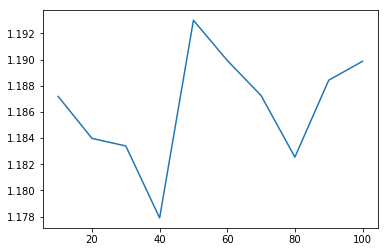

In [12]:
import matplotlib.pyplot as plt
x = []
y = []
epochs = 10
gradientLearningRate = 0.1
for F in range(10,101,10):
    y.append(testRun(F,epochs,gradientLearningRate))
    x.append(F)
plt.plot(x,y)
plt.show()

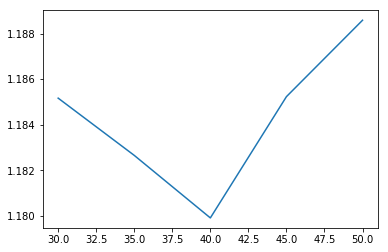

In [14]:
import matplotlib.pyplot as plt
x = []
y = []
epochs = 10
gradientLearningRate = 0.1
for F in range(30,51,5):
    y.append(testRun(F,epochs,gradientLearningRate))
    x.append(F)
plt.plot(x,y)
plt.show()

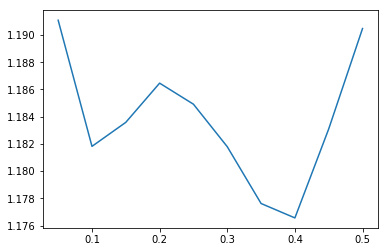

In [18]:
import matplotlib.pyplot as plt
x = []
y = []
F = 40
epochs = 10
for i in range(1,11):
    gradientLearningRate = i*0.05
    y.append(testRun(F,epochs,gradientLearningRate))
    x.append(F)
plt.plot([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],y)
plt.show()

In [ ]:
# ideal F=40, gradientLearningRate = 0.4

In [8]:
A = getA(training)
c = getc(training)
rBar = np.mean(trStats["ratings"])
b = param(A,c)
output = np.zeros((300,97))
for i in range(300):
    for j in range(97):
        output[i,j] = predict([i],[j],rBar,b)
print(output.shape)

(300, 97)
